In [14]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [9]:
new_data = pd.read_csv('Att2CleanData.csv')

In [10]:
x_new_data = new_data.drop(['GoodLoan'], axis=1)
y_new_data = new_data['GoodLoan']

In [11]:
y_new_data.value_counts()

1.0    760344
0.0     56381
Name: GoodLoan, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x_new_data, y_new_data, test_size=0.33, random_state=42)

In [16]:
clf = GradientBoostingClassifier(n_estimators=2, learning_rate=1.0,
                                 max_depth=1, random_state=0).fit(X_train, y_train)

In [17]:
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[ 0.95050346  0.9503664   0.95105125  0.95011879  0.95123355]


In [18]:
clf.score(X_test, y_test)

0.94984045710893439

In [20]:
y_true, y_pred = y_test, clf.predict(X_test)

In [21]:
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.82      0.36      0.50     18839
        1.0       0.95      0.99      0.97    250681

avg / total       0.94      0.95      0.94    269520



In [29]:
main_features = clf.feature_importances_

In [23]:
print(main_features)

[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.98  0.02
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]


In [30]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_new_data.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

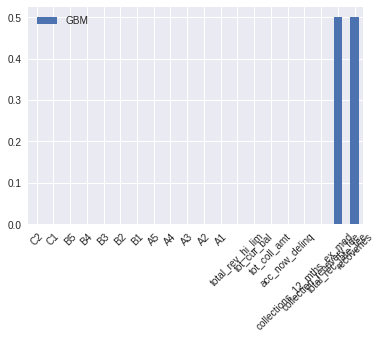

In [31]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'GBM'})
importances.sort_values(by='GBM')[-20:].plot(kind='bar', rot=45)

In [26]:
importances.sort_values(by='GBM')[-20:]

,GBM
C2,0.00
C1,0.00
B5,0.00
B4,0.00
B3,0.00
B2,0.00
B1,0.00
A5,0.00
A4,0.00
A3,0.00
